In [1]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train(energy).csv', 'train.csv']

In [2]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'sle', 'shc', 'she', 'case', 'duty', 'Rate_m3', 'Rate_ton'])

In [3]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [4]:
df = pd.read_csv(root+'train(energy).csv',index_col=0).dropna(axis=0)
print(df.shape)
df.head()

(16499, 69)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Case Conditions_C7+ in Light End (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,Duty_Condenser Heat Duty_Mkcal/hr,Duty_Reboiler Heat Duty_Mkcal/hr,Naphtha Properties_Naphtha Feed Rate_m3/hr,Light End Product Properties_Light End Prod. Rate_m3/hr,Heart Cut Product Properties_Heart Cut Prod. Rate_m3/hr,Heavy End Product Properties_Heavy End Product Rate_m3/hr,Naphtha Properties_Naphtha Feed Rate_ton/hr,Light End Product Properties_Light End Prod. Rate_ton/hr,Heart Cut Product Properties_Heart Cut Prod. Rate_ton/hr,Heavy End Product Properties_Heavy End Product Rate_ton/hr
001-01,10.0,100.0,1.0,2.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,3.891577,4.252277,118.000084,7.997900,100.000198,10.001979,86.475102,5.469008,73.401711,7.604384
001-02,10.0,100.0,1.0,5.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,3.723144,4.071568,118.000000,8.445992,100.000122,9.553886,86.475047,5.797086,73.411102,7.266858
001-03,10.0,100.0,1.0,10.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,3.572479,3.900158,118.000000,9.143384,100.000008,8.856608,86.475047,6.294930,73.435539,6.744582
001-04,10.0,100.0,1.5,2.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,3.442118,3.759819,118.000000,7.284074,100.000275,10.715655,86.475047,4.978351,73.360406,8.136289
001-05,10.0,100.0,1.5,5.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,3.301176,3.607212,118.000084,7.697134,99.999817,10.303131,86.475102,5.280904,73.370414,7.823788


# calculate density

In [5]:
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['NA_density','LE_density','HC_density','HE_density'],index=df.index)
density.head()

,NA_density,LE_density,HC_density,HE_density
001-01,0.732839,0.683806,0.734016,0.760288
001-02,0.732839,0.686371,0.734110,0.760618
001-03,0.732839,0.688468,0.734355,0.761531
001-04,0.732839,0.683457,0.733602,0.759290
001-05,0.732839,0.686087,0.733705,0.759360


# duty

In [6]:
duty = df[col_names['duty']]
duty = duty.drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
duty.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr
001-01,2.280675,4.252277
001-02,2.280843,4.071568
001-03,2.280798,3.900158
001-04,2.280843,3.759819
001-05,2.280675,3.607212


# define X,Y

In [7]:
X = df[col_names['case']].join(df[col_names['xna']])
print(X.shape)
X.head()

(16499, 58)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Case Conditions_C7+ in Light End (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,10.0,100.0,1.0,2.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-02,10.0,100.0,1.0,5.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-03,10.0,100.0,1.0,10.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-04,10.0,100.0,1.5,2.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0
001-05,10.0,100.0,1.5,5.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,1.387972,3.239935,0.574988,1.168977,0.753985,0.220996,0.043999,0.004,0.008,0.0


In [8]:
Y = duty.join(density)
print(Y.shape)
Y.head()

(16499, 6)


,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
001-01,2.280675,4.252277,0.732839,0.683806,0.734016,0.760288
001-02,2.280843,4.071568,0.732839,0.686371,0.734110,0.760618
001-03,2.280798,3.900158,0.732839,0.688468,0.734355,0.761531
001-04,2.280843,3.759819,0.732839,0.683457,0.733602,0.759290
001-05,2.280675,3.607212,0.732839,0.686087,0.733705,0.759360


# build scale

In [9]:
mm = StandardScaler()

# scale features

In [10]:
X[:] = mm.fit_transform(X[:])
X.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Case Conditions_C7+ in Light End (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
001-01,-1.224838,0.0,-0.356337,-0.879930,0.0,0.0,0.0,-1.343512,-1.357031,-1.353882,...,1.136983,1.134381,-0.202566,0.806692,-0.011447,0.80602,-0.009478,0.378338,-0.07463,0.0
001-02,-1.224838,0.0,-0.356337,-0.073376,0.0,0.0,0.0,-1.343512,-1.357031,-1.353882,...,1.136983,1.134381,-0.202566,0.806692,-0.011447,0.80602,-0.009478,0.378338,-0.07463,0.0
001-03,-1.224838,0.0,-0.356337,1.539731,0.0,0.0,0.0,-1.343512,-1.357031,-1.353882,...,1.136983,1.134381,-0.202566,0.806692,-0.011447,0.80602,-0.009478,0.378338,-0.07463,0.0
001-04,-1.224838,0.0,0.541652,-0.879930,0.0,0.0,0.0,-1.343512,-1.357031,-1.353882,...,1.136983,1.134381,-0.202566,0.806692,-0.011447,0.80602,-0.009478,0.378338,-0.07463,0.0
001-05,-1.224838,0.0,0.541652,-0.073376,0.0,0.0,0.0,-1.343512,-1.357031,-1.353882,...,1.136983,1.134381,-0.202566,0.806692,-0.011447,0.80602,-0.009478,0.378338,-0.07463,0.0


# split train test

In [11]:
x_col = X.columns.tolist()
y_col = Y.columns.tolist()
df = shuffle(X.join(Y))

In [12]:
X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]

print(X_train.shape,X_valid.shape,X_test.shape)
print(Y_train.shape,Y_valid.shape,Y_test.shape)

(13199, 58) (1650, 58) (1650, 58)
(13199, 6) (1650, 6) (1650, 6)


# to torch tensor

In [13]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float).cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float).cuda()

# data iter

In [14]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [15]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [16]:
class energy_net(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(energy_net,self).__init__()
        self.fc1 = Linear(input_shape,128)
        self.fc2 = Linear(128,128)
        self.fc3 = Linear(128,output_shape)
    
    def forward(self,x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0)

In [18]:
net = energy_net(len(x_col),len(y_col)).cuda()
net.apply(init_weights)

energy_net(
  (fc1): Linear(in_features=58, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

# forward test

In [19]:
net(X_test)

tensor([[ 0.3588,  0.6941, -0.3223, -0.1195,  0.8889, -0.4012],
        [-0.2095, -0.1056, -0.4237,  0.2929, -0.2079, -0.1836],
        [ 0.7571,  0.0299, -1.1035,  0.1213,  0.0882, -0.3271],
        ...,
        [-0.7849, -0.1312,  0.5451, -1.1031,  0.8777,  0.6340],
        [ 0.2596,  0.0573, -0.1147,  0.2913, -0.1412,  0.4089],
        [-0.3454, -0.1505,  0.8939, -0.2907,  1.3897,  0.3034]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# torchviz

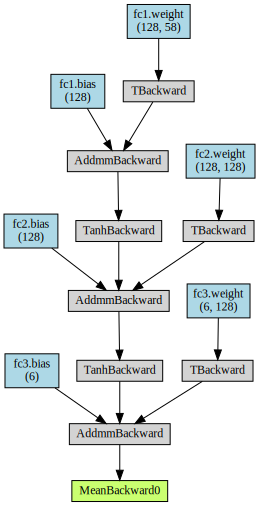

In [20]:
y = net(X_test)
torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))

# tensorboard

In [21]:
with SummaryWriter(comment='Net')as w:
    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [22]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.0005)

# train_loop

In [23]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 3.3343 valid loss 1.7775
record net
epochs 1 train loss 0.9077 valid loss 0.3271
record net
epochs 2 train loss 0.2212 valid loss 0.1519
record net
epochs 3 train loss 0.1153 valid loss 0.1092
record net
epochs 4 train loss 0.0881 valid loss 0.0891
record net
epochs 5 train loss 0.0786 valid loss 0.0868
record net
epochs 6 train loss 0.0732 valid loss 0.0856
record net
epochs 7 train loss 0.0698 valid loss 0.0807
record net
epochs 8 train loss 0.0669 valid loss 0.0772
record net
epochs 9 train loss 0.0650 valid loss 0.0756
record net
epochs 10 train loss 0.0632 valid loss 0.0749
record net
epochs 11 train loss 0.0610 valid loss 0.0708
record net
epochs 12 train loss 0.0592 valid loss 0.0717
epochs 13 train loss 0.0586 valid loss 0.0707
record net
epochs 14 train loss 0.0593 valid loss 0.0700
record net
epochs 15 train loss 0.0559 valid loss 0.0649
record net
epochs 16 train loss 0.0552 valid loss 0.0662
epochs 17 train loss 0.0559 valid loss 0.0726
epochs 18 train l

epochs 162 train loss 0.0084 valid loss 0.0159
epochs 163 train loss 0.0082 valid loss 0.0112
epochs 164 train loss 0.0079 valid loss 0.0100
epochs 165 train loss 0.0083 valid loss 0.0108
epochs 166 train loss 0.0081 valid loss 0.0093
record net
epochs 167 train loss 0.0083 valid loss 0.0101
epochs 168 train loss 0.0082 valid loss 0.0118
epochs 169 train loss 0.0076 valid loss 0.0099
epochs 170 train loss 0.0082 valid loss 0.0101
epochs 171 train loss 0.0082 valid loss 0.0103
epochs 172 train loss 0.0083 valid loss 0.0115
epochs 173 train loss 0.0085 valid loss 0.0112
epochs 174 train loss 0.0091 valid loss 0.0122
epochs 175 train loss 0.0079 valid loss 0.0121
epochs 176 train loss 0.0084 valid loss 0.0109
epochs 177 train loss 0.0078 valid loss 0.0121
epochs 178 train loss 0.0074 valid loss 0.0108
epochs 179 train loss 0.0075 valid loss 0.0137
epochs 180 train loss 0.0073 valid loss 0.0091
record net
epochs 181 train loss 0.0086 valid loss 0.0142
epochs 182 train loss 0.0085 valid los

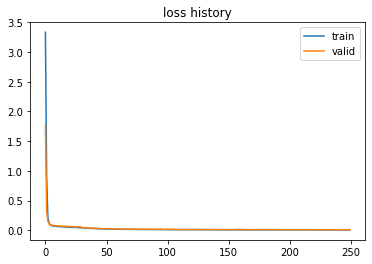

In [24]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=250)

# make prediction

In [25]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.321919,4.254629,0.738066,0.696697,0.736775,0.763534
1,2.395232,4.266102,0.736277,0.675376,0.747756,0.768319
2,2.331997,3.499580,0.743238,0.679182,0.750181,0.758178
3,2.309370,3.139610,0.719629,0.704198,0.732009,0.754250
4,2.327747,3.383831,0.740607,0.687207,0.745786,0.763478


In [26]:
y_real = Y_test.cpu().detach().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.357513,4.259512,0.744517,0.685239,0.749731,0.767921
1,2.379920,4.308903,0.739250,0.674874,0.744766,0.764976
2,2.362701,3.521583,0.753462,0.683709,0.758664,0.776381
3,2.327380,3.204532,0.747420,0.716705,0.749381,0.767155
4,2.308504,3.409458,0.738706,0.679957,0.742063,0.766021


# metric

In [27]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.000994699,0.824819
Duty_Reboiler Heat Duty_Mkcal/hr,0.0222389,1.62404
NA_density,8.68214e-05,0.962391
LE_density,8.05285e-05,0.984501
HC_density,7.40207e-05,0.897394
HE_density,7.11358e-05,0.834886
AVG,0.00392436,1.02134


# wrap model

In [28]:
class ANN_energy_wrapper(object):
    def __init__(self,x_col,y_col,scaler,net):
        self.x_col = x_col
        self.y_col = y_col
        self.scaler = scaler
        self.net = net
    
    def predict(self,x):
        x = self.scaler.transform(x)
        x = torch.tensor(x,dtype=torch.float).cuda()
        y = self.net(x).detach().cpu().numpy()
        y = pd.DataFrame(y,columns=self.y_col)
        return y

In [29]:
model = ANN_energy_wrapper(x_col,y_col,mm,net.eval())

# test ANN_wrapper

In [30]:
df = pd.read_csv(root+'train(energy).csv',index_col=0).sample(1000).dropna(axis=0)
x = df[x_col]
duty = df[col_names['duty']].drop('Duty_Condenser Heat Duty_Mkcal/hr',axis=1)
density = df[col_names['Rate_ton']].values/df[col_names['Rate_m3']].values
density = pd.DataFrame(density,columns=['NA_density','LE_density','HC_density','HE_density'],index=df.index)
y_real = duty.join(density)

In [31]:
x.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C6P- in Heart Cut (Input)_wt%,Case Conditions_C7+ in Light End (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
059-26,30.0,100.0,2.0,5.0,0.0,0.0,0.0,0.001000,0.003000,0.023000,...,1.106989,2.583975,0.332997,0.000000,0.693993,0.000000,0.040000,0.000000,0.008000,0.0
008-10,20.0,100.0,1.0,2.5,0.0,0.0,0.0,0.025999,0.051999,0.428991,...,1.294974,3.021940,0.884982,1.165977,0.732985,0.220996,0.042999,0.004000,0.008000,0.0
161-03,10.0,100.0,1.0,10.0,0.0,0.0,0.0,0.009005,0.017009,0.145080,...,1.199660,2.800540,0.394217,0.595327,0.461254,0.113062,0.027015,0.002001,0.005003,0.0
207-33,30.0,90.0,1.0,2.5,0.0,0.0,0.0,0.055000,0.110000,0.914000,...,1.168000,2.726000,0.755000,1.171000,0.510000,0.221000,0.030000,0.004000,0.006000,0.0
379-31,10.0,90.0,0.3,2.5,0.0,0.0,0.0,0.013000,0.025000,0.209998,...,0.927991,2.165978,0.768992,0.490995,0.559994,0.092999,0.033000,0.002000,0.006000,0.0


# y_real

In [32]:
y_real.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
059-26,2.368405,4.275269,0.735020,0.699008,0.736454,0.762858
008-10,2.344768,5.009132,0.732467,0.677379,0.735651,0.765006
161-03,2.178895,2.693213,0.751197,0.704960,0.750955,0.777666
207-33,2.174130,5.890368,0.745060,0.682160,0.751843,0.772727
379-31,1.938631,3.850939,0.751621,0.695253,0.752390,0.770478


# y_pred

In [33]:
y_pred = model.predict(x)
y_pred.head()

,Duty_E062 3.5K Steam Rate_ton/hr,Duty_Reboiler Heat Duty_Mkcal/hr,NA_density,LE_density,HC_density,HE_density
0,2.367136,4.327716,0.725692,0.704428,0.738211,0.750550
1,2.366475,4.987504,0.738916,0.687988,0.752583,0.765738
2,2.216913,2.717534,0.749139,0.695252,0.758274,0.776998
3,2.148932,5.805417,0.746277,0.682149,0.752417,0.768415
4,1.943784,3.939062,0.736684,0.689958,0.751214,0.767562


In [34]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Duty_E062 3.5K Steam Rate_ton/hr,0.000566884,0.796392
Duty_Reboiler Heat Duty_Mkcal/hr,0.0387939,1.63057
NA_density,8.41457e-05,0.960676
LE_density,8.31e-05,1.03324
HC_density,7.75488e-05,0.914013
HE_density,6.61715e-05,0.806806
AVG,0.00661196,1.02362


In [35]:
# 線性回歸 MSE 0.054 MAPE1.799

# save model

In [36]:
joblib.dump(model,'../model/ANN(energy).pkl')
print('save done!')

save done!
